# Goal: To predict MoA annotations based on drug's biological response

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import summarize

In [2]:
# Set the global characteristics for plt.plots

plt.rc('figure', figsize=(16,9))

# Data Overview

## Acquire and summarize the training dataset of features

**Takeaways**
1. Sig_id is the unqiue identification number and therefor set as the index for the observations.
2. There are 23814 observations.
3. Each observation has 875 columns:
    - Object columns: 2
        - cp_type: has 2 unique values: trt_cp (21948) and ctl_vehicle (1866).
        - cp_does: has 2 unique values: D1 (12147) and D2 (11667). 
    - Number column: 873
        - 772 features are about gene expressions.
        - 100 features are about cell viabilities.
        - cp_time: has 3 unique values: 24 (7772), 48 (8250), and 72(7792)

In [3]:
# Acquire the training dataset

df_features = pd.read_csv("train_features.csv")
df_features.shape

(23814, 876)

In [4]:
# Take a look at first 5 observations

df_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [5]:
# Is sig_id unique? Yes, sig_id is the unique identification number

df_features.duplicated(subset='sig_id').any()

False

In [6]:
# Set the sig_id as the index

df_features.set_index('sig_id', inplace=True)
df_features.shape

(23814, 875)

In [7]:
df_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [8]:
# Address missing values

df_features.isna().sum().sum()

# No missing values are found.

0

In [9]:
# Create a subset of dataframe of object columns only

df_features_obj = summarize.obj_df(df_features)
df_features_obj.shape

(23814, 2)

In [10]:
# Count the unqiue values of the two object columns

summarize.obj_value_counts(df_features)

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64
----------------------------------------------------------------------------------------------------
D1    12147
D2    11667
Name: cp_dose, dtype: int64
----------------------------------------------------------------------------------------------------


In [11]:
# Create a subset of dataframe of number columns only

df_features_num = summarize.num_df(df_features)
df_features_num.shape

(23814, 873)

In [13]:
# Create a dataframe of gene expression cols only

mask_gene_expression = df_features.columns.str.contains('g-')

df_gene_expression = df_features.iloc[:, mask_gene_expression]
df_gene_expression.shape

(23814, 772)

In [14]:
# Create a dataframe of cell viability cols only

mask_viability = df_features.columns.str.contains('c-')

df_cell_viability = df_features.iloc[:, mask_viability]
df_cell_viability.shape

(23814, 100)

In [14]:
# Count the unique values in column cp_time

df_features.cp_time.value_counts().sort_index()

24    7772
48    8250
72    7792
Name: cp_time, dtype: int64

## Visualize Categorical and Contineous features

### Categorical features:
- cp_type
- cp_time
- cp_does

In [9]:
# Create a dataframe with categorical features only

categorical = ['cp_type', 'cp_time', 'cp_dose']

df_categorical = df_features[categorical]
df_categorical.shape

(23814, 3)

In [10]:
# Check the first 5 rows of the dataframe

df_categorical.head()

,cp_type,cp_time,cp_dose
sig_id,,,
id_000644bb2,trt_cp,24,D1
id_000779bfc,trt_cp,72,D1
id_000a6266a,trt_cp,48,D1
id_0015fd391,trt_cp,48,D1
id_001626bd3,trt_cp,72,D2


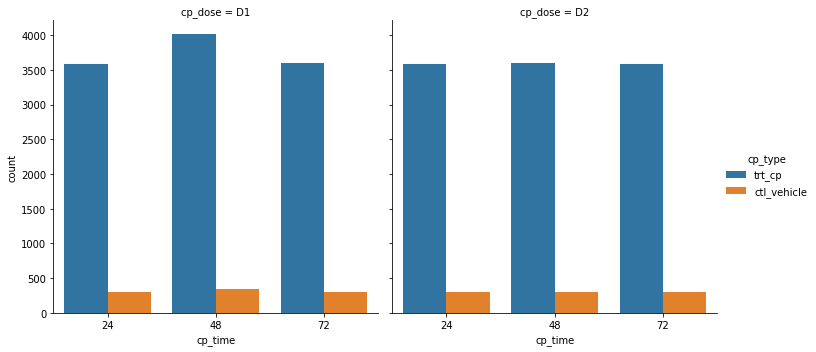

In [11]:
# Visualize the counts of the three categorical features together by sns.catplot()

sns.catplot(x='cp_time', hue='cp_type', col='cp_dose', 
            data=df_categorical, kind='count')

### Contineous features
- g-# as a group 
- c-# as a group

**Takeaways**
- The range of g-# is [-10 to 10] while the range of c-# is [-10, 6.412]. It seems that the raw data from the two methods is processed using the same data processing workflow.
- The higher the g-# and c-# values, the higher gene expression is and more cells are survived.
- Why the minimum value of both are -10? 
- Why c-# value don't have +10 as the max? 

In [15]:
# Recall the created dataframe with g-# features only 

df_gene_expression.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


In [16]:
# Compute descriptive statistics for g-# features

g_stats = df_gene_expression.describe()
g_stats

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,...,0.207299,0.009161,0.171027,0.002316,-0.209799,-0.076251,0.134162,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,...,1.096488,1.200395,1.357701,1.052771,1.201918,1.115477,0.951264,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,...,-8.193000,-10.000000,-9.795000,-8.180000,-10.000000,-10.000000,-4.269000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,...,-0.433875,-0.502250,-0.537075,-0.508775,-0.606175,-0.506200,-0.353100,-0.544600,-0.554400,-0.523800
50%,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,0.160450,...,0.059600,-0.005900,-0.013600,-0.027700,-0.011850,0.009900,0.005400,0.000600,0.028700,-0.006500
75%,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,0.697775,...,0.648500,0.492150,0.522500,0.457000,0.483000,0.511175,0.409075,0.498500,0.496400,0.536950
max,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,6.433000,...,10.000000,9.552000,10.000000,8.346000,5.444000,6.317000,10.000000,5.911000,10.000000,10.000000


In [25]:
# Compute the range of the g_#

min(g_stats.loc['min', :]), max(g_stats.loc['max', :])

(-10.0, 10.0)

Text(0.5, 1.0, 'Distribution of the means of gene expression values from g-0 to g-775')

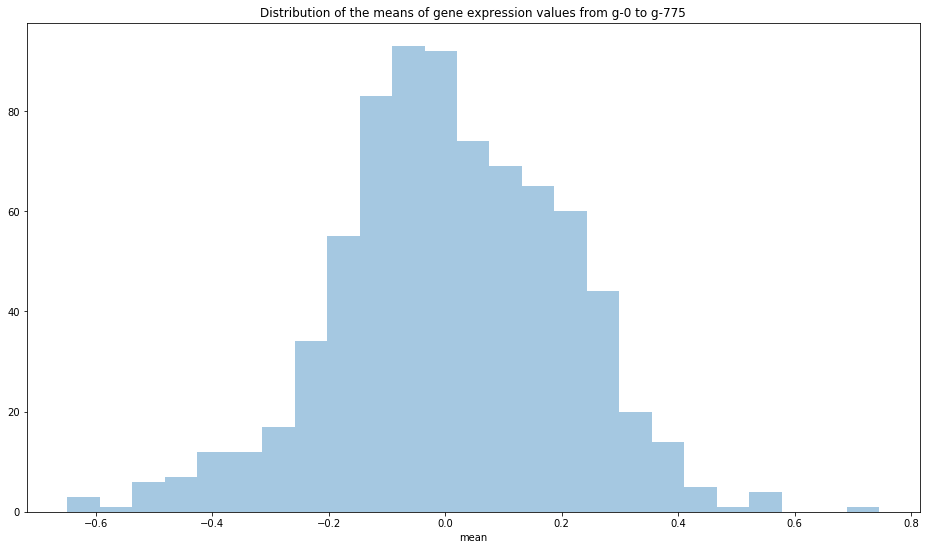

In [17]:
# Plot the distribution of the means of all gene expression values

sns.distplot(g_stats.loc['mean',:], kde=False)
plt.title("Distribution of the means of gene expression values from g-0 to g-775")

Text(0.5, 1.0, 'Boxplot of g-0 expression')

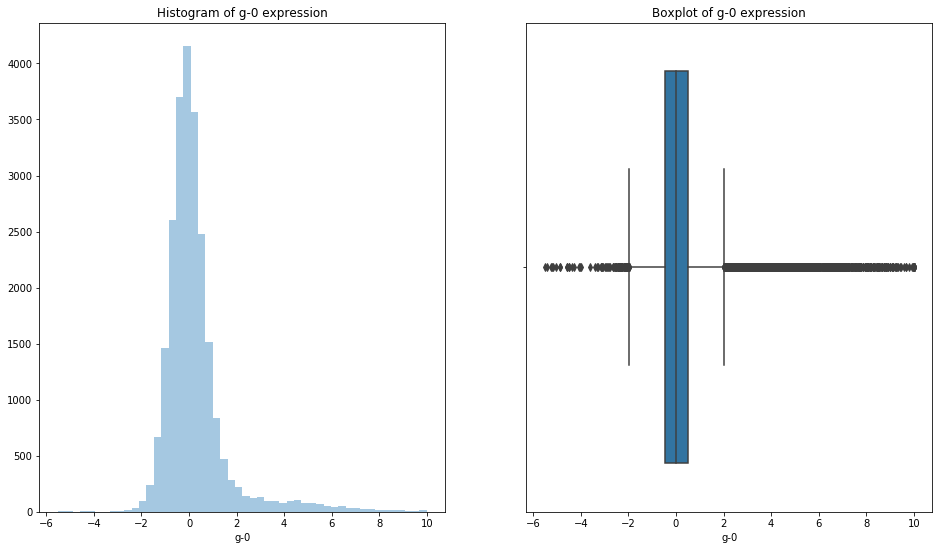

In [18]:
# Visualize the g-0 values for example

plt.subplot(121)
sns.distplot(df_gene_expression['g-0'], kde=False)
plt.title("Histogram of g-0 expression")

plt.subplot(122)
sns.boxplot(df_gene_expression['g-0'])
plt.title("Boxplot of g-0 expression")

In [19]:
# Recall the created dataframe with c-# features only 

df_cell_viability.head()

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,-0.0600,0.1083,0.6864,0.4043,0.4213,-0.6797,0.2888,0.4323,-0.3381,0.3407,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,0.0927,0.2723,0.2772,0.7776,0.3679,0.5696,0.2835,1.4080,0.3745,0.6775,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,-0.1312,-1.4640,0.3394,-1.7790,0.2188,0.5826,-0.7513,0.0543,0.7182,-0.4159,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,-0.3998,-4.5520,-2.7350,-1.9630,-2.8610,-1.2670,-2.5830,-0.5036,-3.1590,-1.8510,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,-0.3774,0.7364,-0.1659,0.2341,1.0060,0.3204,-0.0852,-0.2284,-0.2533,-0.3174,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [23]:
# Compute descriptive statistics for c-# features

c_stats = df_cell_viability.describe()
c_stats

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.355156,-0.455359,-0.480542,-0.377666,-0.493552,-0.446037,-0.574855,-0.266293,-0.451307,-0.458664,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,1.752565,2.004962,2.039346,1.554583,2.091888,1.893484,2.234152,1.465313,1.948829,1.646122,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.549300,-0.538425,-0.550375,-0.601975,-0.559975,-0.578775,-0.571250,-0.524275,-0.551100,-0.654675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,-0.009000,0.009800,-0.004000,-0.039050,0.011400,-0.008900,0.007400,0.006350,-0.005350,-0.025350,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,0.448975,0.476875,0.460575,0.413100,0.470300,0.442675,0.459475,0.469375,0.453175,0.424400,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,3.365000,3.915000,2.970000,2.408000,4.555000,3.614000,3.904000,4.918000,3.648000,3.194000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [24]:
# Compute the range of the c_#

min(c_stats.loc['min', :]), max(c_stats.loc['max', :])

(-10.0, 6.412)

Text(0.5, 1.0, 'Distribution of the means of cell viability data from c-0 and c-99')

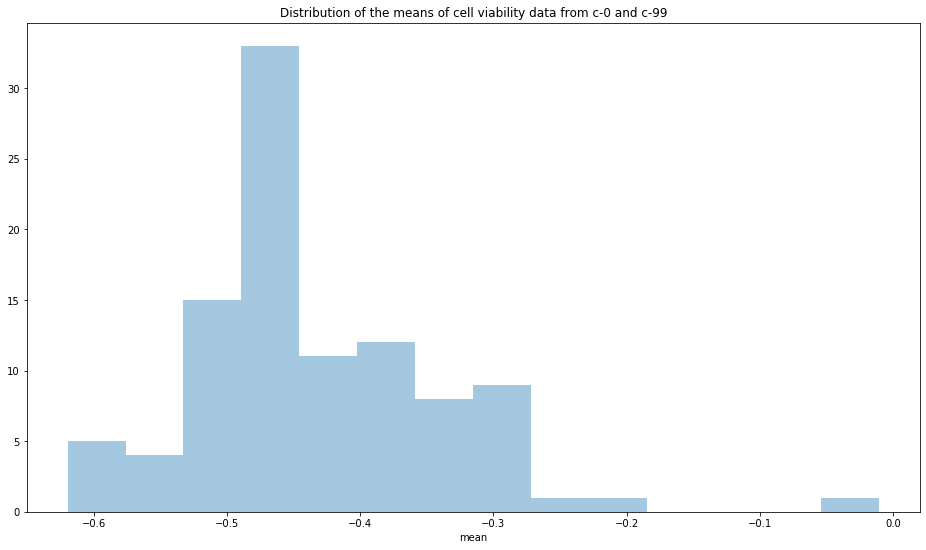

In [26]:
# Plot the distribution of the means of all cell viability values

sns.distplot(c_stats.loc['mean',:], kde=False)
plt.title("Distribution of the means of cell viability data from c-0 and c-99")

Text(0.5, 1.0, 'Boxplot of c-0 data')

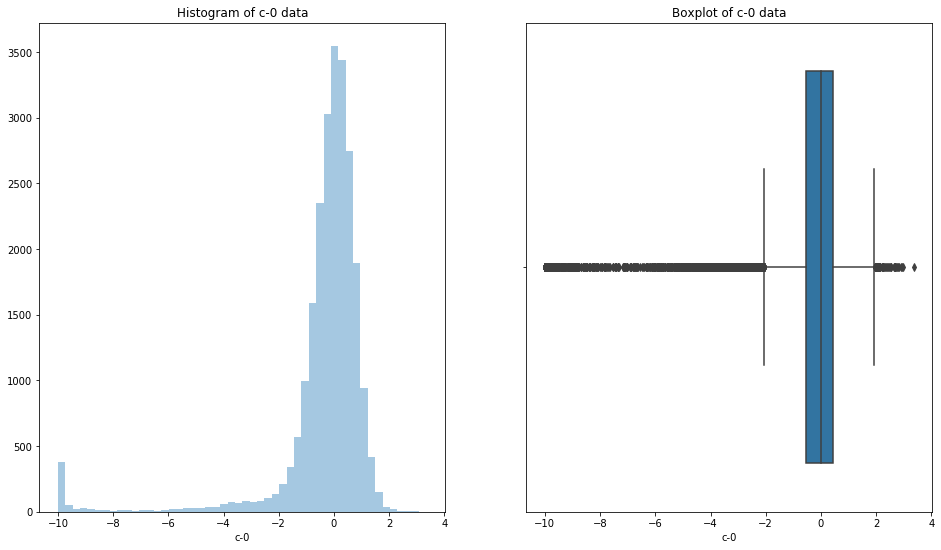

In [27]:
# Visualize the c-0 values for example

plt.subplot(121)
sns.distplot(df_cell_viability['c-0'], kde=False)
plt.title("Histogram of c-0 data")

plt.subplot(122)
sns.boxplot(df_cell_viability['c-0'])
plt.title("Boxplot of c-0 data")

## Acqure and summarize training dataset of MoA Annotations (targets) 

**Takeways**
1. sig_id is unique, no duplicates. So sig_id is set as the index.
2. The total number of targets (labels) are 206. 
3. Group sig_id/observation based on its target numbers.
    - 9367 sig_ids have no MoA targets, among which 1866 are controls.
    - 12532 sig_ids have only 1 MoA target.
    - 1538 sig_ids have 2 targets
    - 303 sig_ids have 3 targets
    - 55 sig_ids have 4 targets
    - 13 sig_ids have 5 targets
    - 6 sig_ids have 7 targets
4. Top 5 MoA Annoations by counts: 
    - 'nfkb_inhibitor' 
    - 'proteasome_inhibitor'
    - 'cyclooxygenase_inhibitor' 
    - 'dopamine_receptor_antagonist'
    - 'serotonin_receptor_antagonist'

In [28]:
# Read train_targets_scored.csv

df_targets = pd.read_csv("train_targets_scored.csv")
df_targets.shape

(23814, 207)

In [29]:
df_targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Any duplicated sig_id? No, the sig_id is unique. 

df_targets.duplicated(subset='sig_id').any()

False

In [31]:
# Set sig_id as the index

df_targets.set_index('sig_id', inplace=True)
df_targets.shape

(23814, 206)

In [32]:
df_targets.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Address missing values

df_targets.isna().sum().sum()

# No missing vlaues are found.

0

In [35]:
# Compute the total number of MoA annotations

total_targets_num = df_targets.shape[1]
total_targets_num

206

In [36]:
# Group sig_id based on the number of its target(s)

col_names = ['num_of_targets', 'num_of_sig_ids']

group_sig_ids = df_targets.sum(axis=1).value_counts().sort_index()
df_group_sig_ids = summarize.pd_series(group_sig_ids, col_names)
df_group_sig_ids

,num_of_targets,num_of_sig_ids
0,0,9367
1,1,12532
2,2,1538
3,3,303
4,4,55
5,5,13
6,7,6


Text(0.5, 1.0, 'Group the observations by the counts of their labels')

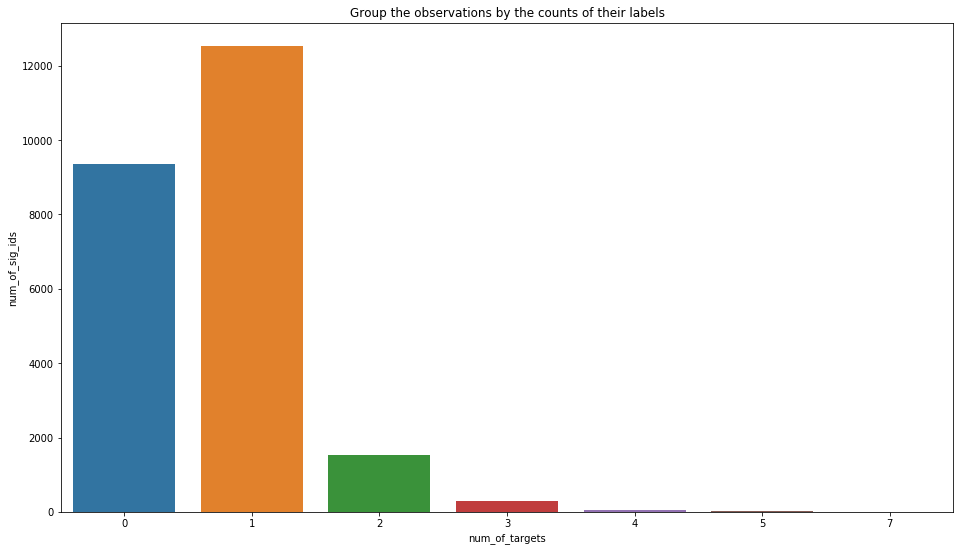

In [37]:
# Visualize the grouping of sig_id based on its number of target. 

summarize.plot_series(group_sig_ids, col_names)
plt.title('Group the observations by the counts of their labels')

In [38]:
# Group MoA annotations by their counts

group_moa = df_targets.sum(axis=0).sort_values(ascending=False)
col_names = ['MoA Annotation', 'Counts']
df_group_moa = summarize.pd_series(group_moa, col_names)
df_group_moa.shape

(206, 2)

In [39]:
# Top 10 MoA annotations by counts

df_group_moa.head(10)

,MoA Annotation,Counts
0,nfkb_inhibitor,832
1,proteasome_inhibitor,726
2,cyclooxygenase_inhibitor,435
3,dopamine_receptor_antagonist,424
4,serotonin_receptor_antagonist,404
5,dna_inhibitor,402
6,glutamate_receptor_antagonist,367
7,adrenergic_receptor_antagonist,360
8,cdk_inhibitor,340
9,egfr_inhibitor,336


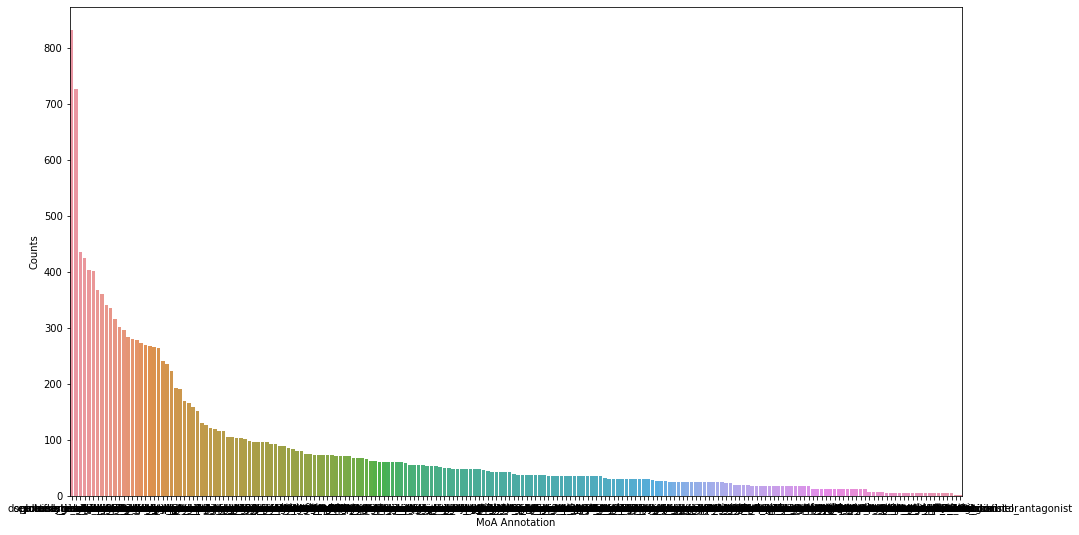

In [40]:
# Plot MoA annotations by counts

summarize.plot_series(group_moa, col_names)

## Break down the features dataframe into the controls and the treated
### Break down the controls dataframe based on cp_type, cp_time and cp_dose

In [41]:
df_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [42]:
# Create a df of control samples only

mask_ctrl = (df_features.cp_type == 'ctl_vehicle')
df_ctrl = df_features[mask_ctrl]
df_ctrl.shape

(1866, 875)

In [43]:
# Create a df of trt samples only

mask_trt = (df_features.cp_type == 'trt_cp')
df_trt = df_features[mask_trt]
df_trt.shape

(21948, 875)

In [44]:
# Further break down df_ctrl based on dose. 

df_ctrl.groupby(['cp_dose', 'cp_time']).size()

cp_dose  cp_time
D1       24         301
         48         343
         72         307
D2       24         305
         48         305
         72         305
dtype: int64

In [45]:
# Create df of controls treated with dose D1 and D2

mask_dose1 = (df_ctrl.cp_dose == 'D1')
mask_dose2 = (df_ctrl.cp_dose == 'D2')

df_ctrl_d1 = df_ctrl[mask_dose1]
df_ctrl_d2 = df_ctrl[mask_dose2]

df_ctrl_d1.shape, df_ctrl_d2.shape

((951, 875), (915, 875))

In [46]:
# Further break down df_ctrl_d1 on treatment time

mask_d1_24 = (df_ctrl_d1.cp_time == 24)
mask_d1_48 = (df_ctrl_d1.cp_time == 48)
mask_d1_72 = (df_ctrl_d1.cp_time == 72)

df_ctrl_d1_24 = df_ctrl_d1[mask_d1_24]
df_ctrl_d1_48 = df_ctrl_d1[mask_d1_48]
df_ctrl_d1_72 = df_ctrl_d1[mask_d1_72]

df_ctrl_d1_24.shape, df_ctrl_d1_48.shape, df_ctrl_d1_72.shape

((301, 875), (343, 875), (307, 875))

In [48]:
# Further break down df_ctrl_d2 on treatment time

mask_d2_24 = (df_ctrl_d2.cp_time == 24)
mask_d2_48 = (df_ctrl_d2.cp_time == 48)
mask_d2_72 = (df_ctrl_d2.cp_time == 72)

df_ctrl_d2_24 = df_ctrl_d2[mask_d2_24]
df_ctrl_d2_48 = df_ctrl_d2[mask_d2_48]
df_ctrl_d2_72 = df_ctrl_d2[mask_d2_72]

df_ctrl_d2_24.shape, df_ctrl_d2_48.shape, df_ctrl_d2_72.shape

((305, 875), (305, 875), (305, 875))

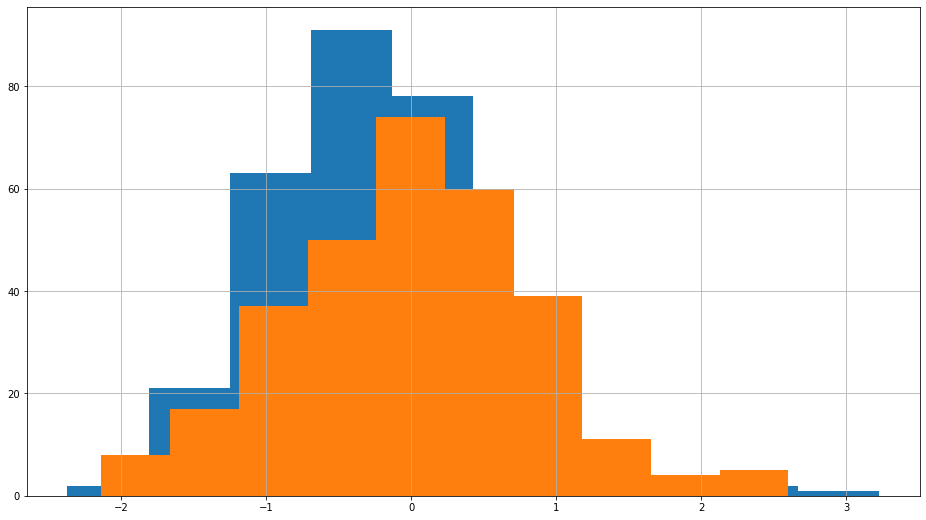

In [49]:
# Take g-0 for example

df_ctrl_d1_24['g-0'].hist()
df_ctrl_d2_24['g-0'].hist()

## Convert the needed dataframe to .csv

In [55]:
# Take a look at the dataframe before write the dataframe to df.csv

df_trt.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [56]:
# Write the dataframe to df.csv

df_trt.to_csv('df_trt.csv')

In [57]:
# Load the same datafrem from df.csv

df = pd.read_csv('df_trt.csv', index_col=0)
df.shape

(21948, 875)

In [58]:
# Compare the loaded dataframe with the original one
# make sure at the first 5 row are identical

df.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
